In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import tensorflow as tf


# Define paths
train_dir = '/kaggle/input/splitted-dataset/Dataset_split/train'
test_dir = '/kaggle/input/splitted-dataset/Dataset_split/test'
val_dir = '/kaggle/input/splitted-dataset/Dataset_split/val'
        

# Preprocessing function
def preprocess_function(img):
    # Convert to numpy array for OpenCV
    img_array = img.astype('uint8')
    # Apply Gaussian blur for noise reduction
    img_array = cv2.GaussianBlur(img_array, (5, 5), 0)
    # Normalize the image to 0-1
    img_array = img_array / 255.0
    # img_array = np.expand_dims(img_array, axis=-1)
    return img_array

# Initiate data generators with the custom preprocessing function
train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_function)
val_data_gen = ImageDataGenerator(preprocessing_function=preprocess_function)
test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_function)

# Create the generators
# Data generators
train_data_gen = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

valid_datagen = ImageDataGenerator(
    rescale=1 / 255.0
)

test_data_gen = ImageDataGenerator(
    rescale=1 / 255.0,
)

train_generator = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='binary'
)

val_generator = valid_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="binary",
    batch_size=32,
    shuffle=False
)

test_generator = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='binary',
    shuffle=False
)


for data_batch, labels_batch in train_generator:
    print("Batch of train data shape:", data_batch.shape)
    print("Batch of train labels shape:", labels_batch.shape)
    break  

for data_batch, labels_batch in val_generator:
    print("Batch of val data shape:", data_batch.shape)
    print("Batch of val labels shape:", labels_batch.shape)
    break  


2024-08-10 14:57:42.513154: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 14:57:42.513272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 14:57:42.672747: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 14000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Found 3000 images belonging to 1 classes.
Batch of train data shape: (32, 224, 224, 3)
Batch of train labels shape: (32,)
Batch of val data shape: (32, 224, 224, 3)
Batch of val labels shape: (32,)


In [2]:
# Check class indices to understand label mapping
print("Training class indices:", train_generator.class_indices)
print("Validation class indices:", val_generator.class_indices)
print("Test class indices:", test_generator.class_indices)

Training class indices: {'Drowsy': 0, 'Non Drowsy': 1}
Validation class indices: {'Drowsy': 0, 'Non Drowsy': 1}
Test class indices: {'all': 0}


Batch of data shape: (32, 224, 224, 3)
Batch of labels shape: (32,)


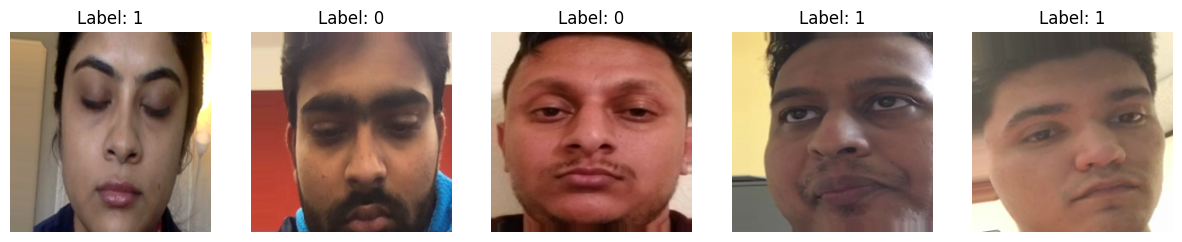

In [3]:
import matplotlib.pyplot as plt

for data_batch, labels_batch in train_generator:
    print("Batch of data shape:", data_batch.shape)
    print("Batch of labels shape:", labels_batch.shape)
    
    # Display a few images from the batch
    num_images_to_display = 5
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images_to_display):
        ax = plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(data_batch[i].squeeze(), cmap='gray')
        plt.title(f"Label: {int(labels_batch[i])}")
        plt.axis("off")
    
    plt.show()
    break

# lable 1 = non drowsy
# label 0 = drowsy

Batch of data shape: (32, 224, 224, 3)
Batch of labels shape: (32,)


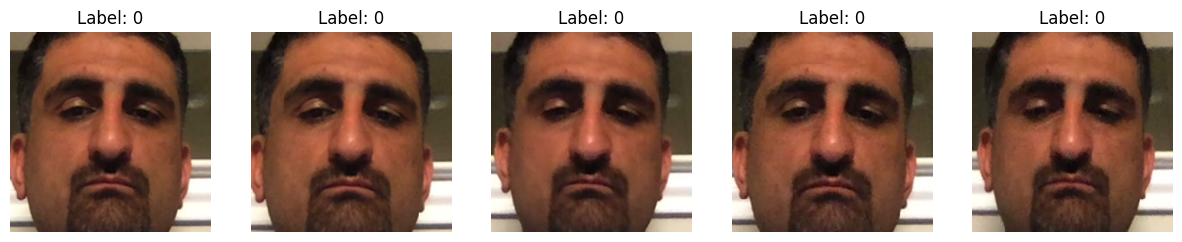

In [4]:
import matplotlib.pyplot as plt

for data_batch, labels_batch in val_generator:
    print("Batch of data shape:", data_batch.shape)
    print("Batch of labels shape:", labels_batch.shape)
    
    # Display a few images from the batch
    num_images_to_display = 5
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images_to_display):
        ax = plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(data_batch[i].squeeze(), cmap='gray')
        plt.title(f"Label: {int(labels_batch[i])}")
        plt.axis("off")
    
    plt.show()
    break

### Base Model

#### Model Architecture 1

In [5]:
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models, optimizers
from keras.callbacks import EarlyStopping
 
# Load the VGG19 model with pretrained weights, excluding the top layer
base_model_vgg = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
 # Freeze the base model layers
base_model_vgg.trainable = False
inputs = layers.Input(shape=(224, 224, 3))
x = base_model_vgg(inputs, training=False)  # Disable training for base model layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # Single unit for binary classification
# Create the model
vgg_model = models.Model(inputs, outputs)


# Compile the model
vgg_model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
vgg_model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,090,177 (76.64 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [6]:
# Train the model
history_vgg = vgg_model.fit(train_generator, epochs=20, validation_data=val_generator)
 
# Evaluate the model on the test set
test_loss, test_accuracy = vgg_model.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/438 ━━━━━━━━━━━━━━━━━━━━ 4:25:27 36s/step - accuracy: 0.4375 - loss: 0.8103

I0000 00:00:1723301941.307614     135 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 338s 690ms/step - accuracy: 0.6459 - loss: 0.6209 - val_accuracy: 0.8967 - val_loss: 0.3462
Epoch 2/20


W0000 00:00:1723302242.776415     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 224s 504ms/step - accuracy: 0.8448 - loss: 0.3674 - val_accuracy: 0.9377 - val_loss: 0.2166
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 223s 501ms/step - accuracy: 0.9048 - loss: 0.2477 - val_accuracy: 0.9587 - val_loss: 0.1469
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 223s 500ms/step - accuracy: 0.9377 - loss: 0.1846 - val_accuracy: 0.9643 - val_loss: 0.1278
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 224s 503ms/step - accuracy: 0.9523 - loss: 0.1471 - val_accuracy: 0.9780 - val_loss: 0.0791
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 223s 500ms/step - accuracy: 0.9564 - loss: 0.1282 - val_accuracy: 0.9793 - val_loss: 0.0693
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 224s 503ms/step - accuracy: 0.9665 - loss: 0.1103 - val_accuracy: 0.9830 - val_loss: 0.0603
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 223s 501ms/step - accuracy: 0.9697 - loss: 0.0895 - val_accuracy: 0.9837 - val_loss: 0.0555
Epoch 9/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 222s 500ms/step - accuracy: 0.9654 - loss: 0.09

In [7]:
# Evaluate the model on the test set
val_loss, val_accuracy = vgg_model.evaluate(val_generator)
print(f'Val loss: {val_loss}')
print(f'Val accuracy: {val_accuracy}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.9912 - loss: 0.0186
Val loss: 0.021344825625419617
Val accuracy: 0.9926666617393494


Accuracy & Loss graph

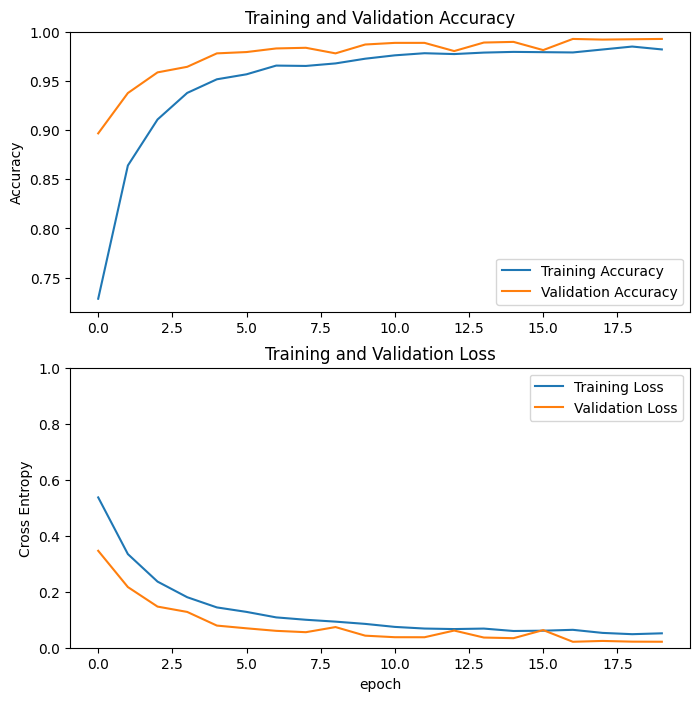

In [8]:
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']

loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Classification report & confusion matrix

94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step


W0000 00:00:1723306591.596558     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix:
[[1487   13]
 [   9 1491]]


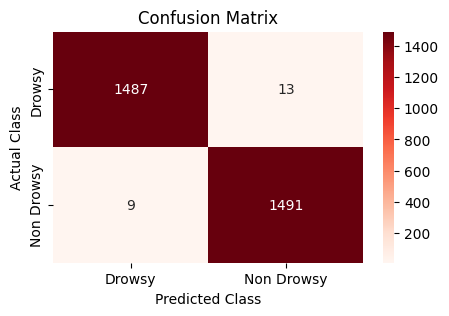


Classification Report:
              precision    recall  f1-score   support

      Drowsy     0.9940    0.9913    0.9927      1500
  Non Drowsy     0.9914    0.9940    0.9927      1500

    accuracy                         0.9927      3000
   macro avg     0.9927    0.9927    0.9927      3000
weighted avg     0.9927    0.9927    0.9927      3000



In [9]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
steps_per_epoch = np.ceil(val_generator.samples / val_generator.batch_size).astype(int)
 
# Get predictions from the model
predictions = vgg_model.predict(val_generator, steps=steps_per_epoch)
 
# Since this is a binary classification, we threshold predictions at 0.5
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)
 
# Get the true classes
true_classes = val_generator.classes
 
# Print the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(5, 3))
class_labels = list(val_generator.class_indices.keys())
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()
 
# Print the classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=list(val_generator.class_indices.keys()), digits=4))

#### Model Architecture 2

In [10]:
# Load the VGG19 model with pretrained weights, excluding the top layer
base_model_vgg2 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the base model layers
base_model_vgg2.trainable = False
inputs = layers.Input(shape=(224, 224, 3))
x = base_model_vgg2(inputs, training=False)  # Disable training for base model layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # Single unit for binary classification
# Create the model
vgg_model2 = models.Model(inputs, outputs)


# Compile the model
vgg_model2.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
vgg_model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,090,177 (76.64 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [11]:
initial_epochs = 10
 
# Train the model
history_vgg2 = vgg_model2.fit(train_generator, epochs=initial_epochs, validation_data=val_generator)
 
# Evaluate the model on the val set
val_loss, val_accuracy = vgg_model2.evaluate(val_generator)
print(f'Val loss: {val_loss}')
print(f'Val accuracy: {val_accuracy}')

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 229s 508ms/step - accuracy: 0.6342 - loss: 0.6348 - val_accuracy: 0.8547 - val_loss: 0.3660
Epoch 2/10


W0000 00:00:1723306858.978280     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 222s 500ms/step - accuracy: 0.8471 - loss: 0.3733 - val_accuracy: 0.9280 - val_loss: 0.2264
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 225s 505ms/step - accuracy: 0.9021 - loss: 0.2629 - val_accuracy: 0.9543 - val_loss: 0.1449
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 223s 502ms/step - accuracy: 0.9271 - loss: 0.2027 - val_accuracy: 0.9653 - val_loss: 0.1046
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 224s 504ms/step - accuracy: 0.9478 - loss: 0.1539 - val_accuracy: 0.9743 - val_loss: 0.0793
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 225s 505ms/step - accuracy: 0.9539 - loss: 0.1376 - val_accuracy: 0.9620 - val_loss: 0.1253
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 222s 499ms/step - accuracy: 0.9605 - loss: 0.1204 - val_accuracy: 0.9840 - val_loss: 0.0563
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 223s 502ms/step - accuracy: 0.9707 - loss: 0.0925 - val_accuracy: 0.9673 - val_loss: 0.1060
Epoch 9/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 224s 503ms/step - accuracy: 0.9684 - loss: 0.09

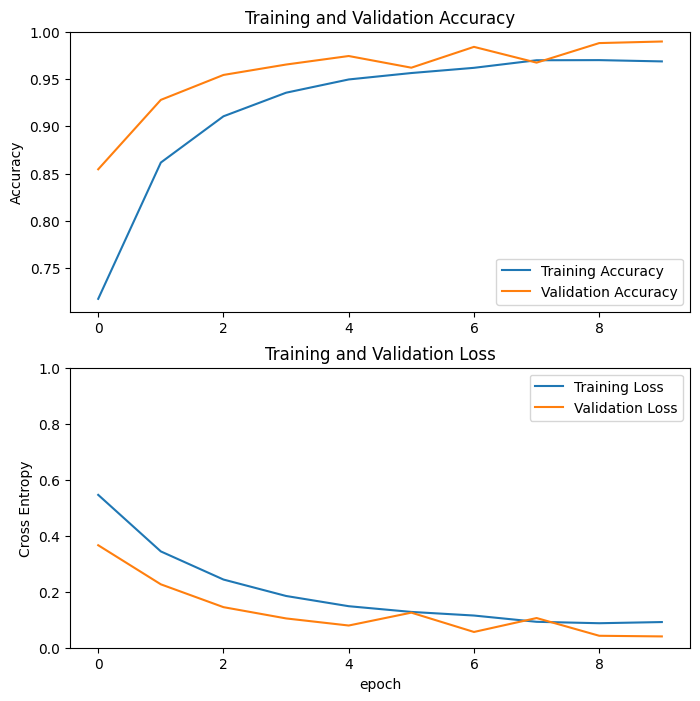

In [13]:
acc = history_vgg2.history['accuracy']
val_acc = history_vgg2.history['val_accuracy']

loss = history_vgg2.history['loss']
val_loss = history_vgg2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine Tuning

In [14]:
# unfreeze the base model layer
base_model_vgg2.trainable = True
#print the number of layer available
print("Number of layers in the base model: ", len(base_model_vgg2.layers))

Number of layers in the base model:  22


In [15]:
base_model_vgg2.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Fine-tune from this layer onwards
fine_tune_at = 12

# Freeze all the layers before the stated layer
for layer in base_model_vgg2.layers[:fine_tune_at]:
  layer.trainable = False
base_model_vgg2.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 17,698,816 (67.52 MB)

 Non-trainable params: 2,325,568 (8.87 MB)

In [17]:
#compile model with small learning rate
vgg_model2.compile(optimizer=optimizers.Adam(learning_rate=1e-05), 
                   loss='binary_crossentropy', metrics=['accuracy'])
vgg_model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,090,177 (76.64 MB)

 Trainable params: 17,764,609 (67.77 MB)

 Non-trainable params: 2,325,568 (8.87 MB)

In [18]:
fine_tune_epochs = 10 
total_epochs =  initial_epochs + fine_tune_epochs
#continue train from last epoch
history_fine = vgg_model2.fit(train_generator, epochs=total_epochs,initial_epoch=history_vgg2.epoch[-1], validation_data=val_generator)
 
# Evaluate the model on the val set
val_loss, val_accuracy = vgg_model2.evaluate(val_generator)
print(f'Val loss: {val_loss}')
print(f'Val accuracy: {val_accuracy}')

Epoch 10/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 249s 525ms/step - accuracy: 0.9623 - loss: 0.1282 - val_accuracy: 0.9993 - val_loss: 0.0027
Epoch 11/20


W0000 00:00:1723309276.611578     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 227s 509ms/step - accuracy: 0.9957 - loss: 0.0174 - val_accuracy: 0.9997 - val_loss: 0.0025
Epoch 12/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 225s 507ms/step - accuracy: 0.9978 - loss: 0.0061 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 13/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 225s 505ms/step - accuracy: 0.9982 - loss: 0.0071 - val_accuracy: 0.9997 - val_loss: 0.0024
Epoch 14/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 225s 506ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 0.9997 - val_loss: 0.0032
Epoch 15/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 226s 508ms/step - accuracy: 0.9987 - loss: 0.0046 - val_accuracy: 1.0000 - val_loss: 1.5907e-05
Epoch 16/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 226s 509ms/step - accuracy: 0.9986 - loss: 0.0042 - val_accuracy: 1.0000 - val_loss: 4.9336e-05
Epoch 17/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 226s 507ms/step - accuracy: 0.9991 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 4.4605e-05
Epoch 18/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 226s 508ms/step - accuracy: 

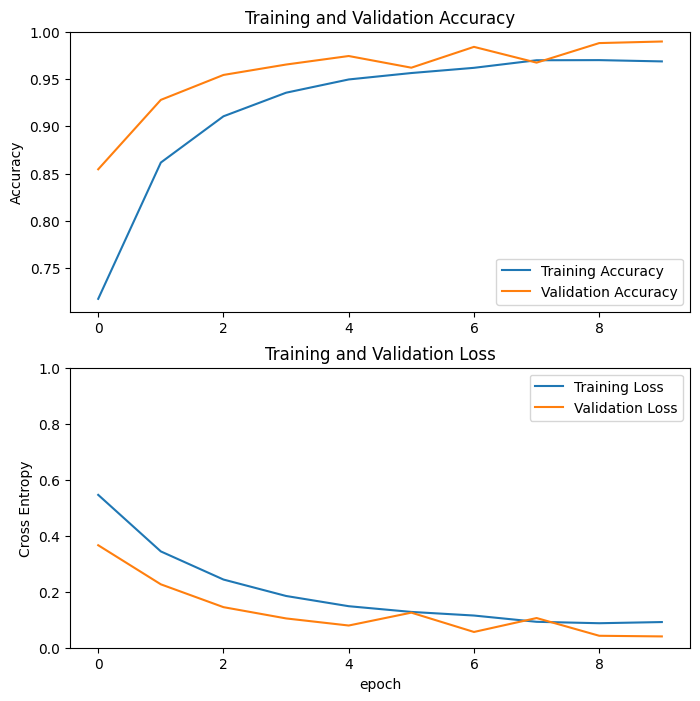

In [20]:
acc = history_vgg2.history['accuracy']
val_acc = history_vgg2.history['val_accuracy']

loss = history_vgg2.history['loss']
val_loss = history_vgg2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

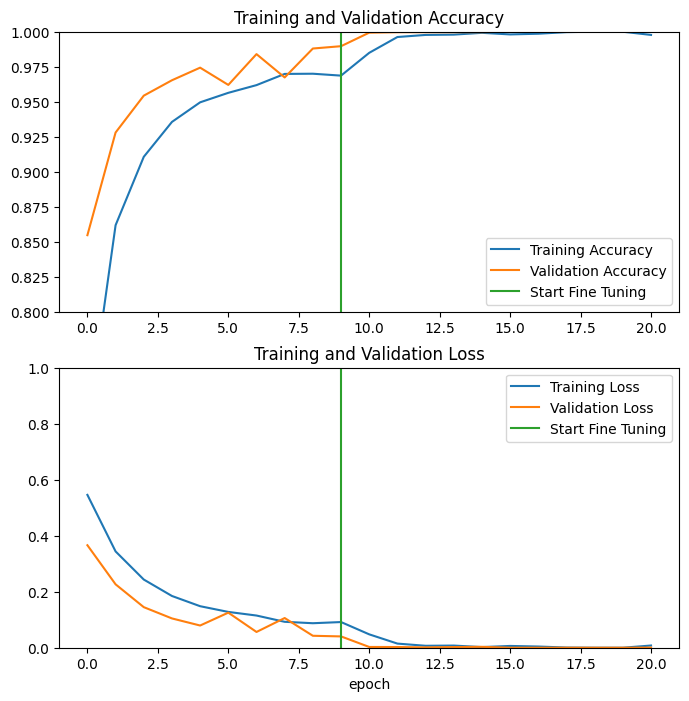

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step


W0000 00:00:1723311622.481436     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix:
[[1500    0]
 [   0 1500]]


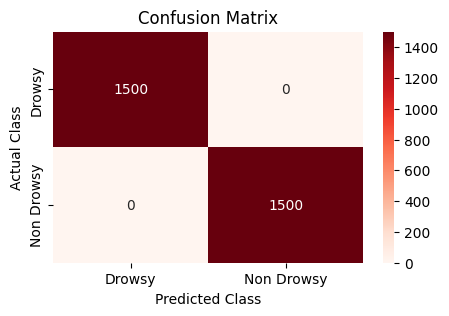


Classification Report:
              precision    recall  f1-score   support

      Drowsy     1.0000    1.0000    1.0000      1500
  Non Drowsy     1.0000    1.0000    1.0000      1500

    accuracy                         1.0000      3000
   macro avg     1.0000    1.0000    1.0000      3000
weighted avg     1.0000    1.0000    1.0000      3000



In [23]:
steps_per_epoch = np.ceil(val_generator.samples / val_generator.batch_size).astype(int)
 
# Get predictions from the model
predictions = vgg_model2.predict(val_generator, steps=steps_per_epoch)
 
# Since this is a binary classification, we threshold predictions at 0.5
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)
 
# Get the true classes
true_classes = val_generator.classes
 
# Print the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(5, 3))
class_labels = list(val_generator.class_indices.keys())
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()
 
# Print the classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=list(val_generator.class_indices.keys()), digits=4))

#### Model Architechure 3

In [49]:
# Load the VGG19 model with pretrained weights, excluding the top layer
base_model_vgg3 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the base model layers
base_model_vgg3.trainable = False
inputs = layers.Input(shape=(224, 224, 3))
x = base_model_vgg3(inputs, training=False) 
x = layers.GlobalAveragePooling2D()(x)
# Fully connected layers with L2 regularization, and batch normalization
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # Single unit for binary classification
# Create the model
vgg_model3 = models.Model(inputs, outputs)


# Compile the model
vgg_model3.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
vgg_model3.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,090,689 (76.64 MB)

 Trainable params: 66,049 (258.00 KB)

 Non-trainable params: 20,024,640 (76.39 MB)

In [50]:
initial_epochs = 10
 
# Train the model
history_vgg3 = vgg_model3.fit(train_generator, epochs=initial_epochs, validation_data=val_generator)
 
# Evaluate the model on the val set
val_loss, val_accuracy = vgg_model3.evaluate(val_generator)
print(f'Val loss: {val_loss}')
print(f'Val accuracy: {val_accuracy}')

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 230s 508ms/step - accuracy: 0.8129 - loss: 1.2087 - val_accuracy: 0.8290 - val_loss: 0.5209
Epoch 2/10


W0000 00:00:1723321919.771731     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 224s 504ms/step - accuracy: 0.9377 - loss: 0.3151 - val_accuracy: 0.8880 - val_loss: 0.3425
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 223s 501ms/step - accuracy: 0.9444 - loss: 0.2432 - val_accuracy: 0.7270 - val_loss: 0.7956
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 225s 506ms/step - accuracy: 0.9373 - loss: 0.2367 - val_accuracy: 0.8793 - val_loss: 0.3560
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 225s 505ms/step - accuracy: 0.9432 - loss: 0.2200 - val_accuracy: 0.9430 - val_loss: 0.2218
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 225s 505ms/step - accuracy: 0.9451 - loss: 0.2178 - val_accuracy: 0.9073 - val_loss: 0.2907
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 224s 503ms/step - accuracy: 0.9510 - loss: 0.2021 - val_accuracy: 0.9693 - val_loss: 0.1464
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 223s 502ms/step - accuracy: 0.9500 - loss: 0.1987 - val_accuracy: 0.9807 - val_loss: 0.1169
Epoch 9/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 223s 502ms/step - accuracy: 0.9517 - loss: 0.19

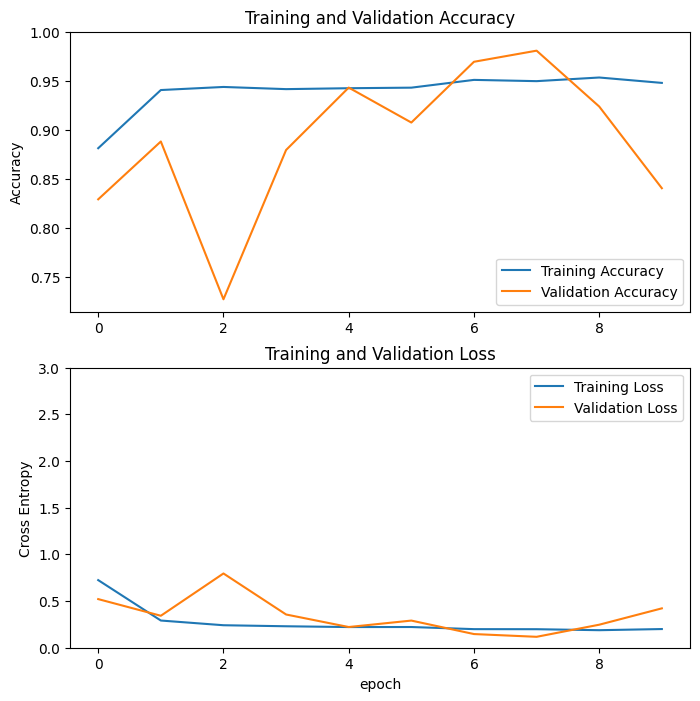

In [51]:
acc = history_vgg3.history['accuracy']
val_acc = history_vgg3.history['val_accuracy']

loss = history_vgg3.history['loss']
val_loss = history_vgg3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [52]:
# Fine-tune from this layer onwards
fine_tune_at = 12
base_model_vgg3.trainable = True
# Freeze all the layers before the stated layer
for layer in base_model_vgg3.layers[:fine_tune_at]:
  layer.trainable = False
base_model_vgg3.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 17,698,816 (67.52 MB)

 Non-trainable params: 2,325,568 (8.87 MB)

In [53]:
#compile model with small learning rate
vgg_model3.compile(optimizer=optimizers.Adam(learning_rate=1e-05), 
                   loss='binary_crossentropy', metrics=['accuracy'])
vgg_model3.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,090,689 (76.64 MB)

 Trainable params: 17,764,865 (67.77 MB)

 Non-trainable params: 2,325,824 (8.87 MB)

In [54]:
fine_tune_epochs = 10 
total_epochs =  initial_epochs + fine_tune_epochs
#continue train from last epoch
history_fine3 = vgg_model3.fit(train_generator, epochs=total_epochs,initial_epoch=history_vgg2.epoch[-1], validation_data=val_generator)

# Evaluate the model on the test set
# Evaluate the model on the val set
val_loss, val_accuracy = vgg_model3.evaluate(val_generator)
print(f'Val loss: {val_loss}')
print(f'Val accuracy: {val_accuracy}')

Epoch 10/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 234s 512ms/step - accuracy: 0.9755 - loss: 0.1305 - val_accuracy: 0.9993 - val_loss: 0.0610
Epoch 11/20


W0000 00:00:1723324238.454406     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 226s 508ms/step - accuracy: 0.9983 - loss: 0.0692 - val_accuracy: 0.9997 - val_loss: 0.0562
Epoch 12/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 227s 510ms/step - accuracy: 0.9997 - loss: 0.0614 - val_accuracy: 0.9933 - val_loss: 0.0654
Epoch 13/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 226s 508ms/step - accuracy: 0.9988 - loss: 0.0597 - val_accuracy: 0.9997 - val_loss: 0.0494
Epoch 14/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 226s 508ms/step - accuracy: 0.9992 - loss: 0.0546 - val_accuracy: 0.9997 - val_loss: 0.0468
Epoch 15/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 227s 509ms/step - accuracy: 0.9998 - loss: 0.0494 - val_accuracy: 1.0000 - val_loss: 0.0440
Epoch 16/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 225s 507ms/step - accuracy: 1.0000 - loss: 0.0455 - val_accuracy: 1.0000 - val_loss: 0.0410
Epoch 17/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 225s 505ms/step - accuracy: 0.9999 - loss: 0.0421 - val_accuracy: 1.0000 - val_loss: 0.0380
Epoch 18/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 224s 504ms/step - accuracy: 0.9996 - los

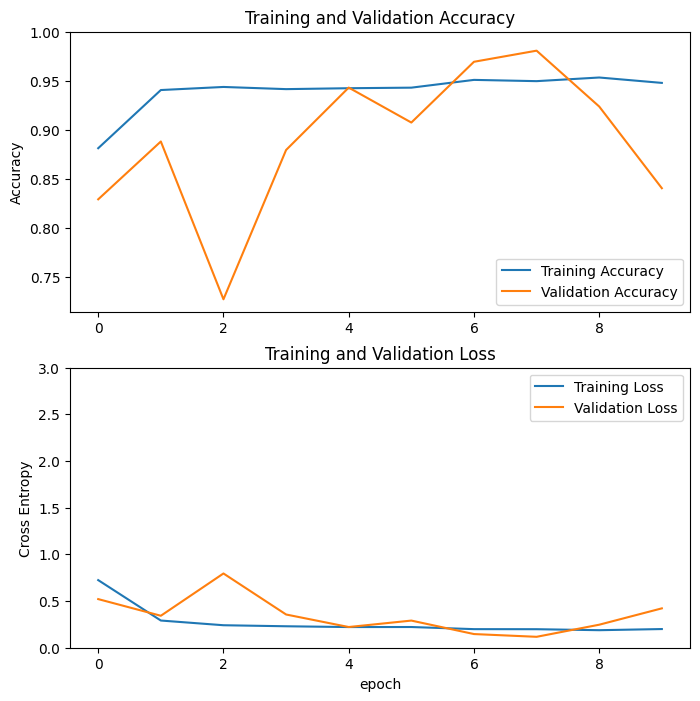

In [55]:
acc = history_vgg3.history['accuracy']
val_acc = history_vgg3.history['val_accuracy']

loss = history_vgg3.history['loss']
val_loss = history_vgg3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [58]:
acc += history_fine3.history['accuracy']
val_acc += history_fine3.history['val_accuracy']

loss += history_fine3.history['loss']
val_loss += history_fine3.history['val_loss']

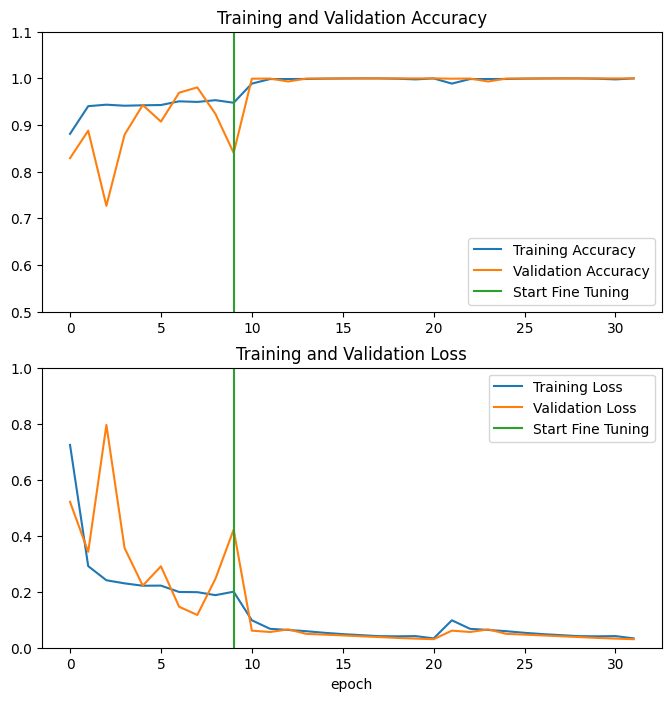

In [63]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1.1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step


W0000 00:00:1723326692.439824     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix:
[[1500    0]
 [   0 1500]]


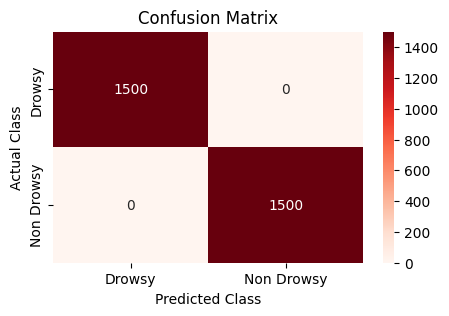


Classification Report:
              precision    recall  f1-score   support

      Drowsy     1.0000    1.0000    1.0000      1500
  Non Drowsy     1.0000    1.0000    1.0000      1500

    accuracy                         1.0000      3000
   macro avg     1.0000    1.0000    1.0000      3000
weighted avg     1.0000    1.0000    1.0000      3000



In [62]:
steps_per_epoch = np.ceil(val_generator.samples / val_generator.batch_size).astype(int)
 
# Get predictions from the model
predictions = vgg_model3.predict(val_generator, steps=steps_per_epoch)
 
# Since this is a binary classification, we threshold predictions at 0.5
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)
 
# Get the true classes
true_classes = val_generator.classes
 
# Print the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(5, 3))
class_labels = list(val_generator.class_indices.keys())
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()
 
# Print the classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=list(val_generator.class_indices.keys()), digits=4))

### Hyperparameter Tuning (Optuna - Random Search)

In [ ]:
import optuna
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models, optimizers
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard

# Hyperprameter Tuning
def build_best_arc_model(trial):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    # Freeze the base model layers
    base_model.trainable = False
    inputs = layers.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(trial.suggest_int('dense_unit', 32, 128, step = 16), activation='relu')(x)
    x = layers.Dropout(trial.suggest_float('droputout_rate', 0, 0.5, log = False, step = 0.1))(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)

    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def objective(trial):
    best_model = build_best_arc_model(trial)
    batch_size = trial.suggest_int('batch_size', 32, 128, step = 16)
    epochs = trial.suggest_int('epoch', 10, 40, step = 10)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = best_model.fit(
        train_generator,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=val_generator,
        callbacks=[early_stopping]
    )
    
    val_accuracy = np.mean(history.history['val_accuracy'])
    return val_accuracy
 
# Create a study and optimize
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_name = 'vgg19_ht'
study = optuna.create_study(study_name=study_name, load_if_exists=True,storage='sqlite:///vgg19_ht.db',direction='maximize')
study.optimize(objective, n_trials=10)

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best accuracy:', study.best_value)

Best hyperparameters: {'dense_unit': 32, 'droputout_rate': 0.2, 'learning_rate': 0.0019283207494851396, 'batch_size': 128, 'epoch': 20}
Best accuracy: 0.9774166703224182


### Tuned Model

In [ ]:
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models, optimizers
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
 
# Load the VGG19 model with pretrained weights, excluding the top layer
tuned_base_model_vgg = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
 # Freeze the base model layers
tuned_base_model_vgg.trainable = False
inputs = layers.Input(shape=(224, 224, 3))
x = tuned_base_model_vgg(inputs, training=False)  # Disable training for base model layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # Single unit for binary classification
# Create the model
tuned_vgg_model = models.Model(inputs, outputs)


# Compile the model
learning_rate=0.0019283207494851396
tuned_vgg_model.compile(optimizer=optimizers.Adam(learning_rate = learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
tuned_vgg_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,040,833 (76.45 MB)

 Trainable params: 16,449 (64.25 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tuned_history_vgg = tuned_vgg_model.fit(train_generator, epochs=20,batch_size = 128, validation_data=val_generator, callbacks=[early_stopping])
val_loss, val_accuracy = tuned_vgg_model.evaluate(val_generator)
print(f'Val loss: {val_loss}')
print(f'Val accuracy: {val_accuracy}')

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/438 ━━━━━━━━━━━━━━━━━━━━ 4:41:46 39s/step - accuracy: 0.3750 - loss: 1.0206

I0000 00:00:1723409660.069451     133 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723409660.094850     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/438 ━━━━━━━━━━━━━━━━━━━━ 2:51 720ms/step - accuracy: 0.5932 - loss: 0.6788

W0000 00:00:1723409803.542901     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.6486 - loss: 0.6212

W0000 00:00:1723409955.605992     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723410006.261199     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 385s 792ms/step - accuracy: 0.6488 - loss: 0.6210 - val_accuracy: 0.8987 - val_loss: 0.3229
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 231s 520ms/step - accuracy: 0.8688 - loss: 0.3386 - val_accuracy: 0.9507 - val_loss: 0.1805
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 231s 520ms/step - accuracy: 0.9186 - loss: 0.2284 - val_accuracy: 0.9627 - val_loss: 0.1231
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 233s 522ms/step - accuracy: 0.9414 - loss: 0.1676 - val_accuracy: 0.9707 - val_loss: 0.0948
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 232s 522ms/step - accuracy: 0.9511 - loss: 0.1374 - val_accuracy: 0.9653 - val_loss: 0.1147
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 234s 526ms/step - accuracy: 0.9652 - loss: 0.1092 - val_accuracy: 0.9730 - val_loss: 0.0816
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 231s 519ms/step - accuracy: 0.9726 - loss: 0.0908 - val_accuracy: 0.9833 - val_loss: 0.0653
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 233s 523ms/step - accuracy: 0.9726 - loss: 0.08

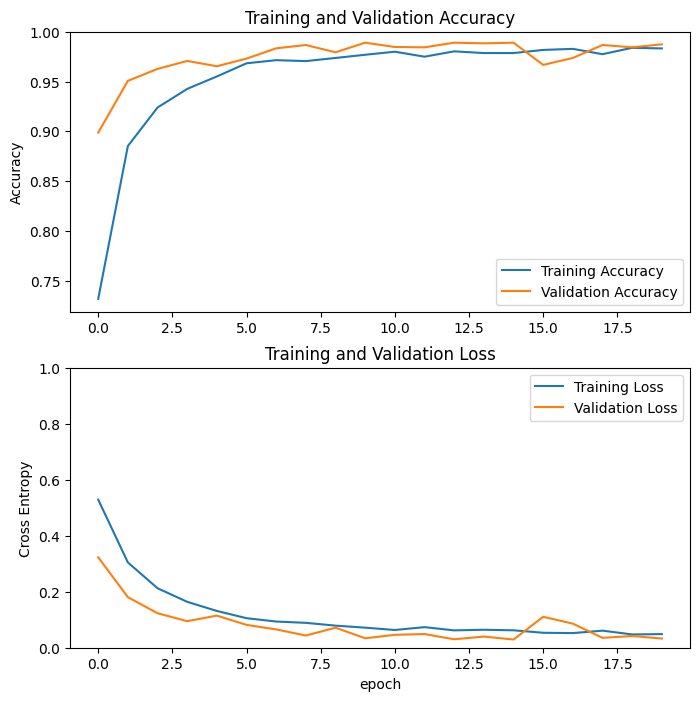

In [ ]:
acc = tuned_history_vgg.history['accuracy']
val_acc = tuned_history_vgg.history['val_accuracy']

loss = tuned_history_vgg.history['loss']
val_loss = tuned_history_vgg.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

 2/94 ━━━━━━━━━━━━━━━━━━━━ 15s 172ms/step 

W0000 00:00:1723414470.582180     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step


W0000 00:00:1723414484.269463     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix:
[[1482   18]
 [  15 1485]]


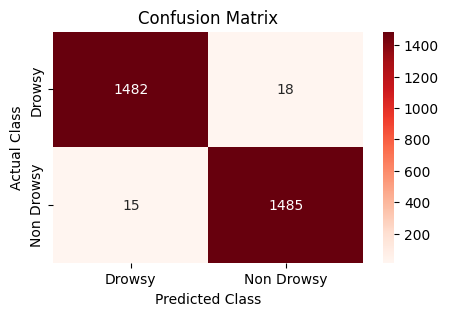


Classification Report:
              precision    recall  f1-score   support

      Drowsy     0.9900    0.9880    0.9890      1500
  Non Drowsy     0.9880    0.9900    0.9890      1500

    accuracy                         0.9890      3000
   macro avg     0.9890    0.9890    0.9890      3000
weighted avg     0.9890    0.9890    0.9890      3000



In [ ]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
steps_per_epoch = np.ceil(val_generator.samples / val_generator.batch_size).astype(int)
 
# Get predictions from the model
predictions = tuned_vgg_model.predict(val_generator, steps=steps_per_epoch)
 
# Since this is a binary classification, we threshold predictions at 0.5
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)
 
# Get the true classes
true_classes = val_generator.classes
 
# Print the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(5, 3))
class_labels = list(val_generator.class_indices.keys())
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()
 
# Print the classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=list(val_generator.class_indices.keys()), digits=4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


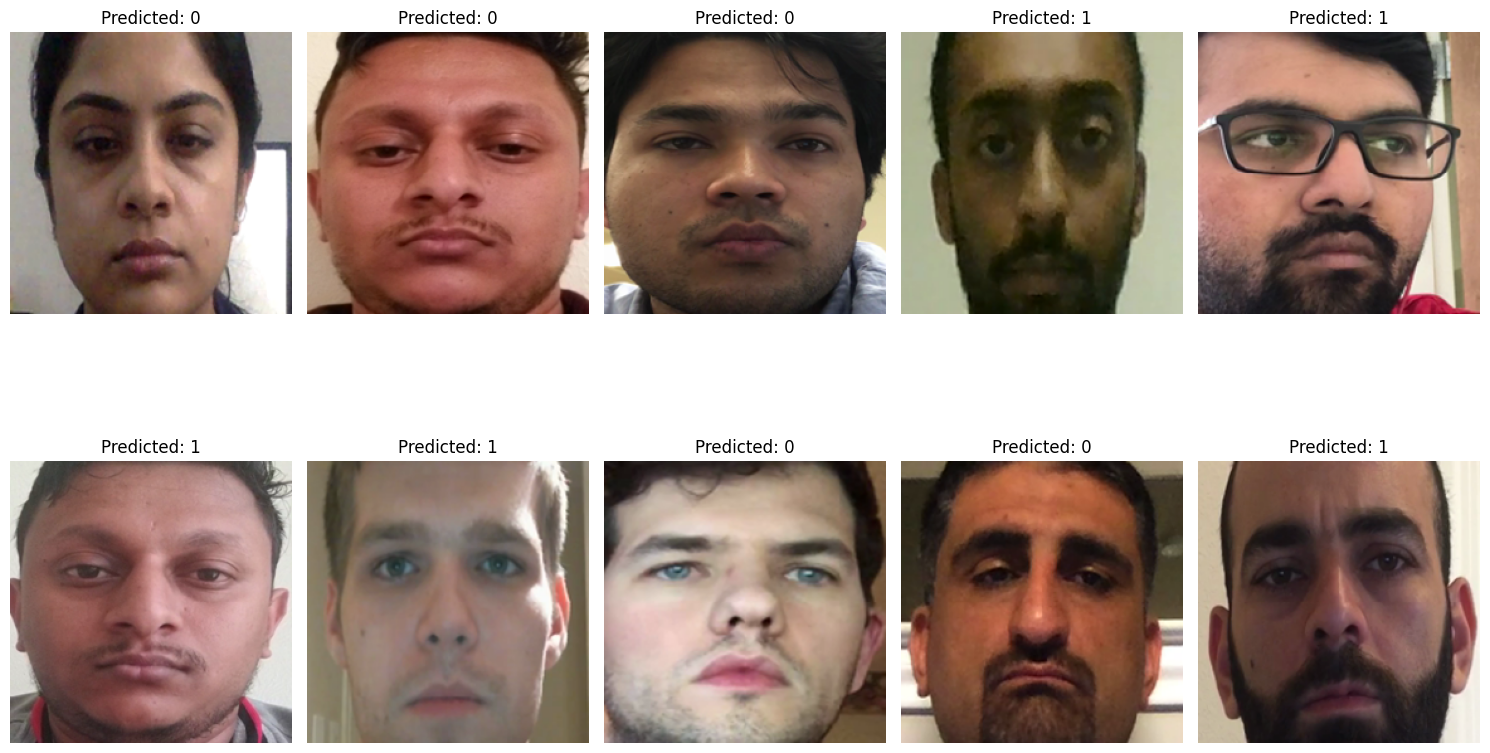

In [ ]:
# Result with test dataset
images, labels = next(test_generator)
first_10_images = images[:10]

# Make predictions
predictions = tuned_vgg_model.predict(first_10_images)
predicted_classes = np.argmax(predictions, axis=1) if test_generator.class_mode != 'binary' else (predictions > 0.5).astype('int32')
predicted_classes = predicted_classes.flatten()

# Display the images along with their predicted labels
plt.figure(figsize=(15, 10))

for i in range(len(first_10_images)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(first_10_images[i].squeeze(), cmap='gray')
    plt.title(f"Predicted: {predicted_classes[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()